# stacking_fault_multi Calculation Demonstration

- - -

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Office of Data and Informatics, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2017-07-24

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 
 
- - -

## Introduction

This Notebook describes the methodology for both the __stacking_fault__ and __stacking_fault_multi__ calculations.

The __stacking_fault__ calculation evaluates the energy of a single generalized stacking fault shift along a specified crystallographic plane. In other words, this evaluates only a single configuration. This calculation script is better for evaluating critical points with known shifts, or for implementation in an intelligent workflow.   

The __stacking_fault_multi__ calculation evaluates the full 2D generalized stacking fault map for an array of shifts along a specified crystallographic plane. A regular grid of points is established and the generalized stacking fault energy is evaluated at each. This calculation script is better optimized for generating the full GSF maps as it reduces simulation setup time and all values are saved to a single record.

__Disclaimer #1__: The system's dimension perpendicular to the fault plane should be large to minimize the interaction of the free surface and the stacking fault.

__Disclaimer #2__: Currently, the rotation capabilities of atomman limit this calculation such that only cubic prototypes can be rotated. Properties of non-cubic structures can still be explored, as long as the configuration being loaded has the plane of interest perpendicular to one of the three box vectors.

- - -

## Method and Theory

A perfect crystal system is constructed in which two of the system's boundary conditions are periodic and the third is non-periodic (defined by the calculation using cutboxvector). To ensure that the shift is properly handled across the periodic directions, the box vector, $\vec{a}$, $\vec{b}$, or $\vec{c}$, assigned to cutboxvector must have a Cartesian $x$, $y$, or $z$ component that the other two box vectors do not. If true, then the non-periodic boundary will be perpendicular to that Cartesian axis, and the periodic box vectors will be parallel to the cut plane.

For LAMMPS compatible systems, the above rule places the following limitations on allowed systems:

- cutboxvector = 'c': all systems allowed.

- cutboxvector = 'b': the system's yz tilt must be zero.

- cutboxvector = 'a': the system's xy and xz tilts must be zero.

Once the system is constructed, a LAMMPS simulation performs an energy/force minimization and evaluates the system's total potential energy, $E^{total}(\vec{0})$. 

A mathematical fault plane is defined in the middle of the system parallel to the free surface plane created by the non-periodic boundary. All atoms on one side of the fault plane are then shifted by a vector contained within the fault plane, $\vec{s}$. After shifting, the system is subjected to an energy/force minimization where all atoms are only allowed to relax normal to the plane, and the system's total potential energy, $E^{total}(\vec{s})$, is measured.

For the stacking_fault calculation, only one shift is applied. For the stacking_fault_multi calculation, a regular array of points is constructed based on two non-parallel vectors, $\vec{s_1}$ and $\vec{s_2}$, that are in the fault plane. These two shift vectors should each correspond to a full periodic shift of the plane such that applying the full shift results in a system equivalent to the unshifted configuration. The evaluation grid is then constructed by taking fractional steps along both shift vectors.

The generalized stacking fault energy, $E_{GSF}(\vec{s})$, is then measured as

$$ E_{GSF}(\vec{s}) = \frac{E^{total}(\vec{s}) - E^{total}(\vec{0})}{A_{fault}},$$

where $A_{fault}$ is the area of the fault plane.

Additionally, the relaxation normal to the glide plane, $\Delta\delta_{GSF}$,  is characterized by finding the change in the centers of mass of the shifted and unshifted regions perpendicular to the glide plane.

- - -

## Demonstration

### 1. Library imports

Import libraries needed by the calculation. The external libraries used are:

- [numpy](http://www.numpy.org/)

- [pandas](https://pandas.pydata.org/)

- [DataModelDict](https://github.com/usnistgov/DataModelDict)

- [atomman](https://github.com/usnistgov/atomman)

- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from __future__ import division, absolute_import, print_function
import os
import sys
import uuid
import shutil
import datetime
from copy import deepcopy

# http://www.numpy.org/
import numpy as np 

# https://pandas.pydata.org/
import pandas as pd

# https://github.com/usnistgov/DataModelDict 
from DataModelDict import DataModelDict as DM

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

# https://github.com/usnistgov/iprPy
import iprPy

Import plotting library for the Notebook

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

### 2. Assign values for the calculation's run parameters

#### 2.0 Set the calculation's working directory

In [3]:
calc_name = 'stacking_fault_multi'

# Check current working directory
cwd_name = os.path.basename(os.getcwd())

# Change working directory if needed
if cwd_name != calc_name:
    if not os.path.isdir(calc_name):
        os.mkdir(calc_name)
    os.chdir(calc_name)

#### 2.1 Specify system-specific paths

Simple input parameters:

- __lammps_command__ is the LAMMPS command to use.

- __mpi_command__ MPI command for running LAMMPS in parallel. A value of None will run simulations serially.

- __lib_directory__ defines the relative path to the iprPy library. This makes it easier to define paths to reference records later.

In [4]:
lammps_command = 'lmp_serial'
mpi_command = None
lib_directory = '../../../library'

#### 2.2 Specify the potenital and elemental symbols

Simple input parameters:

- __potential_name__ gives the name of the potential_LAMMPS reference record in the iprPy library to use for potential. 

- __symbols__ is a list of the elemental model symbols of potential to associate with the unique atom types of system.

Derived parameters:

- __potential_dir_path__ gives the path for the folder containing the artifacts associated with the potential (i.e. eam.alloy file). If an empty string '' is given, the necessary artifacts are taken as being in the working directory. (Here, it is derived from lib_directory and potential_name.)

- __potential_path__ gives the path to the potential_LAMMPS reference record to use. (Here, it is derived from lib_directory and potential_name.)

- __potential__ is the atomman.lammps.Potential representation of a LAMMPS implemented potential to use. (Here, the class is implemented using potential_path and potential_dir_path.)

In [5]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'
symbols = ['Ni']

# -------------- Derived parameters -------------- #
# Define potential_path and potential_dir_path using lib_directory and potential_name
potential_dir_path = os.path.abspath(os.path.join(lib_directory, 'potential_LAMMPS', potential_name))
potential_path = potential_dir_path + '.json'

# Create potential by loading LAMMPS-potential record
potential = lmp.Potential(potential_path, potential_dir_path)

print('Successfully loaded potential', potential)

Successfully loaded potential 1999--Mishin-Y--Ni--LAMMPS--ipr1


#### 2.3 Specify the prototype unit cell system

Simple input parameters:

- __prototype_name__ gives the name of the crystal_prototype reference record in the iprPy library to use for ucell. 

- __box_parameters__ defines the box parameters to scale ucell to. This is a list of either three or six floats
    - __[a, b, c]__ are the orthogonal lattice parameters in length units.
    - __[a, b, c, alpha, beta, gamma]__ are the triclinic lattice parameters in length units and angles in degrees.

Derived parameters:

- __prototype_path__ gives the path to the crystal_prototype reference record to use. (Here, it is derived from lib_directory and prototype_name).

- __ucell__ is an atomman.System representing a fundamental unit cell of the system. (Here, it is loaded from prototype_path file, then scaled using box_parameters).

In [6]:
prototype_name = 'A1--Cu--fcc'
box_parameters = uc.set_in_units([3.52, 3.52, 3.52], 'angstrom')

# -------------- Derived parameters -------------- #
# Define prototype_path using lib_directory and prototype_name
prototype_path = os.path.abspath(os.path.join(lib_directory, 'crystal_prototype', prototype_name+'.json'))

# Create ucell by loading prototype record
ucell = am.load('system_model', prototype_path)[0]

# Rescale ucell using box_parameters
if len(box_parameters) == 3:
    ucell.box_set(a=box_parameters[0], b=box_parameters[1], c=box_parameters[2], scale=True)
elif len(box_parameters) == 6:
    ucell.box_set(a=box_parameters[0], b=box_parameters[1], c=box_parameters[2], scale=True,
                  alpha=box_parameters[3], beta=box_parameters[4], gamma=box_parameters[5])

print(ucell)

avect =  [ 3.520,  0.000,  0.000]
bvect =  [ 0.000,  3.520,  0.000]
cvect =  [ 0.000,  0.000,  3.520]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   1.760 |   1.760
      2 |       1 |   1.760 |   0.000 |   1.760
      3 |       1 |   1.760 |   1.760 |   0.000


#### 2.4 Specify the defect 

Simple input parameters:

- __stackingfault_name__ gives the name of the stacking_fault reference record in the iprPy library to use for potential. 

Derived parameters:

- __stackingfault_path__ gives the path to the stacking_fault reference record to use. (Here, it is derived from lib_directory and stackingfault_name).

- __stackingfault_model__ is a DataModelDict of a stacking_fault record. (Here, the stackingfault_path file is loaded as a DataModelDict.)

- __stackingfault_kwargs__ is a dictionary containing parameters for generating the defect. Values are extracted from the stackingfault_model record and uniquely define a type of stacking fault. Included keywords are:

    - __crystallographic-axes__ specifies how to orient the system. Subelements define each of the x-, y-, and z-axes.
    
    - __cutboxvector__ specifies which box vector to apply the free surface cut to.
    
    - __atomshift__ is a 3D vector rigid-body shift to apply to atoms in the system. The atomshift vector is relative to the rotated unit cell's box vectors.
    
    - __plane-position__ specifies the location to place the fault plane relative to the box vector being cut of the rotated unit cell. 
    
    - __shift-vector-1, shift-vector-2__ are two non-parallel crystallographic shifting vectors within the fault plane.

In [7]:
stackingfault_name = 'A1--Cu--fcc--111sf'

# -------------- Derived parameters -------------- #
# Define stackingfault_path using lib_directory and stackingfault_name
stackingfault_path = os.path.abspath(os.path.join(lib_directory, 'stacking_fault', stackingfault_name+'.json')) 

# Load stacking-fault record as a DataModelDict
with open(stackingfault_path) as f:
    stackingfault_model = DM(f)

print('Successfully loaded defect record for', stackingfault_model['stacking-fault']['id'])

# Extract defect parameters    
stackingfault_kwargs = stackingfault_model['stacking-fault']['calculation-parameter']

print(stackingfault_kwargs.json(indent=4))

Successfully loaded defect record for A1--Cu--fcc--111sf
{
    "x_axis": " 1 -1  0", 
    "y_axis": " 1  1 -2", 
    "z_axis": " 1  1  1", 
    "atomshift": " 0.01  0.01  0.01", 
    "cutboxvector": "c", 
    "faultpos": 0.5, 
    "shiftvector1": " 0.5 -0.5  0.0", 
    "shiftvector2": " 0.5  0.5 -1.0"
}


#### 2.5 Generate the initial system

Simple input parameters:

- __sizemults__ list of three integers or three tuple pairs of integers specifying how many times (and in which direction) the ucell vectors of $a$, $b$ and $c$ are replicated in creating system.

Defect model parameters:

- __x_axis__ is the 3D crystal vector relative to ucell to align with the x-axis of system.

- __y_axis__ is the 3D crystal vector relative to ucell to align with the y-axis of system.

- __z_axis__ is the 3D crystal vector relative to ucell to align with the z-axis of system.

- __atomshift__ is a 3D vector rigid-body shift to apply to atoms in the system. The atomshift vector is relative to the rotated unit cell's box vectors.

Derived parameters:

- __axes__ is a 3x3 array combining x_axis, y_axis and z_axis.

- __shift__ is a 3D vector rigid-body shift to apply to atoms in the system. The shift vector is in absolute Cartesian units. (Here, it is derived from atomshift).

- __system__ is the base atomman.System to use. (Here, it is derived by copying ucell, rotating according to axes, applying shift, then sizemults

In [8]:
sizemults = [5,5,5]

# -------------- Defect parameters --------------- #
x_axis = np.array(stackingfault_kwargs['x_axis'].split(), dtype=float)
y_axis = np.array(stackingfault_kwargs['y_axis'].split(), dtype=float)
z_axis = np.array(stackingfault_kwargs['z_axis'].split(), dtype=float)
atomshift = np.array(stackingfault_kwargs['atomshift'].split(), dtype=float)

# -------------- Derived parameters -------------- #
# Copy ucell to initialsystem
system = deepcopy(ucell)

# Build axes from x_axis, y_axis and z_axis
axes = np.array([x_axis, y_axis, z_axis])

# Rotate using axes
system = am.rotate_cubic(system, axes)

# Convert atomshift to shift using the rotated system
shift = (atomshift[0] * system.box.avect 
         + atomshift[1] * system.box.bvect 
         + atomshift[2] * system.box.cvect)

# Apply shift
system.atoms_prop(key='pos', value=system.atoms_prop(key='pos') + shift)

# Apply sizemults
system.supersize(*sizemults)

print('# of atoms in system =', system.natoms)

# of atoms in system = 3000


#### 2.6 Specify calculation-specific run parameters

Simple input parameters:

- __numshifts1__ is the number of shifts to take along shiftvector1.

- __numshifts2__ is the number of shifts to take along shiftvector2.

- __energytolerance__ is the energy tolerance to use during the minimizations. This is unitless.

- __forcetolerance__ is the force tolerance to use during the minimizations. This is in energy/length units.

- __maxiterations__ is the maximum number of minimization iterations to use.

- __maxevaluations__ is the maximum number of minimization evaluations to use.

- __maxatommotion__ is the largest distance that an atom is allowed to move during a minimization iteration. This is in length units.

Defect model parameters

- __cutboxvector__ defines which of the three system box vector boundaries ($a$, $b$, or $c$) the system will be cut along to create the free surface.

- __planepos_ucell__ specifies the location to place the fault plane relative to the box vector being cut of the rotated unit cell.

- __shiftvector1_crystal__ is a 3D crystal vector relative to ucell that defines one of the shiftvectors.

- __shiftvector2_crystal__ is a 3D crystal vector relative to ucell that defines one of the shiftvectors.

Derived parameters

- __T__ is the transformation matrix associated with axes.

- __shiftvector1__ is one of the shiftvectors in absolute Cartesian units. This is obtained by scaling shiftvector1_crystal by the unit cell box vectors, and then transforming to the defined axes.

- __shiftvector2__ is one of the shiftvectors in absolute Cartesian units. This is obtained by scaling shiftvector2_crystal by the unit cell box vectors, and then transforming to the defined axes.

- __planepos__ is the fractional position to place the fault plane relative to the full initial system. This is derived using planepos_ucell and sizemults such that the fault is placed in one of the middle cell replicas, and always in the same relative position within the cell replica.

In [9]:
numshifts1 = 11
numshifts2 = 11

energytolerance = 1e-8
forcetolerance = uc.set_in_units(0.0, 'eV/angstrom')
maxiterations = 10000
maxevaluations = 100000
maxatommotion = uc.set_in_units(0.01, 'angstrom')

# -------------- Defect parameters --------------- #
planepos_ucell = float(stackingfault_kwargs['faultpos'])
cutboxvector = stackingfault_kwargs['cutboxvector']
shiftvector1_crystal = np.array(stackingfault_kwargs['shiftvector1'].split(), dtype=float)
shiftvector2_crystal = np.array(stackingfault_kwargs['shiftvector2'].split(), dtype=float)

# -------------- Derived parameters -------------- #
# Scale and transform the shiftvectors
T = am.tools.axes_check(axes)
shiftvector1 = T.dot(shiftvector1_crystal[0] * ucell.box.avect + 
                     shiftvector1_crystal[1] * ucell.box.bvect + 
                     shiftvector1_crystal[2] * ucell.box.cvect)

shiftvector2 = T.dot(shiftvector2_crystal[0] * ucell.box.avect + 
                     shiftvector2_crystal[1] * ucell.box.bvect + 
                     shiftvector2_crystal[2] * ucell.box.cvect)

# Define planepos shift function
def shift_planepos(p, m):
    """This shifts planepos, p, based on system multiplier, m"""
    # If m is odd, keep p=0.5 at 0.5 
    if m % 2 == 1: 
        return (p + (m-1) * 0.5) / m        
    # If m is even, keep p=0.0 at 0.5
    else:          
        return (2 * p + m) / (2 * m)

# Convert planepos_ucell to planepos
if   cutboxvector == 'a': m = sizemults[0]
elif cutboxvector == 'b': m = sizemults[1]
elif cutboxvector == 'c': m = sizemults[2]
    
if isinstance(m, (list, tuple)):
    m = m[1] - m[0]
    
faultpos = shift_planepos(planepos_ucell, m)

### 3. Define calculation function(s) and generate template LAMMPS script(s)

#### 3.1 sfmin.template

This is a template LAMMPS script for performing an energy minimization for a system with a stacking fault.

In [10]:
with open('sfmin.template', 'w') as f:
    f.write("""#LAMMPS input script that performs an energy minimization
#for a system with a stacking fault

<atomman_system_info>

<atomman_pair_info>

<fix_cut_setforce>

thermo_style custom step lx ly lz pxx pyy pzz pe
thermo_modify format float %.13e

compute peatom all pe/atom 

min_modify dmax <dmax>

dump dumpit all custom <maxeval> <sim_directory>*.dump id type x y z c_peatom
dump_modify dumpit format <dump_modify_format>

minimize <etol> <ftol> <maxiter> <maxeval>
""")

#### 3.2 stackingfaultpoint()

This function creates a system with a stacking fault shift, relaxes the system, and computes the system's total potential energy and center of mass difference between the atoms on either side of the fault plane. 

Arguments:

- __lammps_command__ is the LAMMPS command to use.

- __system__ is an atomman.System to perform the scan on.

- __potential__ is the atomman.lammps.Potential representation of a LAMMPS implemented potential to use.

- __symbols__ is a list of element-model symbols for the Potential that correspond to system's atypes.

- __mpi_command__ MPI command for running LAMMPS in parallel. Default value is None (serial run).  

- __sim_directory__ is the directory to save log and dump files to. Default value is None (save to current working directory).

- __cutboxvector__ is the system box vector boundary along which to make the free surface cut. Default value is 'c'.

- __faultpos__ is the position to place the fault plane. This is relative to the system's box vector associated with cutboxvector. Default value is 0.5 (center of the system).

- __faultshift__ is the 3D atomic shift vector in length units to apply to the atoms on the positive side of the fault position. Default value is [0.0, 0.0, 0.0] (No shift).

- __etol__ is the energy tolerance to use for the minimizations. Default value is 0.0 (don't consider energy).

- __ftol__ is the energy tolerance to use for the minimizations. Default value is 0.0 (don't consider force). If given, this should be in atomman's working energy/length units.

- __maxiter__ is the maximum number of minimization iterations to perform. Default value is 10000.

- __maxeval__ is the maximum number of minimization evaluations to perform. Default value is 100000.

- __dmax__ is the maximum distance an atom is allowed to move per minimization iteration. Default value is 0.01 Angstroms.

In [11]:
def stackingfaultpoint(lammps_command, system, potential, symbols,
                       mpi_command=None, sim_directory=None,
                       cutboxvector='c', faultpos=0.5,
                       faultshift=[0.0, 0.0, 0.0], etol=0.0, ftol=0.0,
                       maxiter=10000, maxeval=100000,
                       dmax=uc.set_in_units(0.01, 'angstrom'),
                       lammps_date=None):
    """
    Perform a stacking fault relaxation simulation for a single faultshift.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    system : atomman.System
        The system to perform the calculation on.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    symbols : list of str
        The list of element-model symbols for the Potential that correspond to
        system's atypes.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    sim_directory : str, optional
        The path to the directory to perform the simuation in.  If not
        given, will use the current working directory.
    etol : float, optional
        The energy tolerance for the structure minimization. This value is
        unitless. (Default is 0.0).
    ftol : float, optional
        The force tolerance for the structure minimization. This value is in
        units of force. (Default is 0.0).
    maxiter : int, optional
        The maximum number of minimization iterations to use (default is 
        10000).
    maxeval : int, optional
        The maximum number of minimization evaluations to use (default is 
        100000).
    dmax : float, optional
        The maximum distance in length units that any atom is allowed to relax
        in any direction during a single minimization iteration (default is
        0.01 Angstroms).
    cutboxvector : str, optional
        Indicates which of the three system box vectors, 'a', 'b', or 'c', to
        cut with a non-periodic boundary (default is 'c').
    faultpos : float, optional
        The fractional position along the cutboxvector where the stacking
        fault plane will be placed (default is 0.5).
    faultshift : list of float, optional
        The vector shift to apply to all atoms above the fault plane defined
        by faultpos (default is [0,0,0], i.e. no shift applied).
    lammps_date : datetime.date or None, optional
        The date version of the LAMMPS executable.  If None, will be identified from the lammps_command (default is None).
    
    Returns
    -------
    dict
        Dictionary of results consisting of keys:
        
        - **'logfile'** (*str*) - The filename of the LAMMPS log file.
        - **'dumpfile'** (*str*) - The filename of the LAMMPS dump file
          of the relaxed system.
        - **'system'** (*atomman.System*) - The relaxed system.
        - **'A_fault'** (*float*) - The area of the fault surface.
        - **'E_total'** (*float*) - The total potential energy of the relaxed
          system.
        - **'disp'** (*float*) - The center of mass difference between atoms
          above and below the fault plane in the cutboxvector direction.
    
    Raises
    ------
    ValueError
        For invalid cutboxvectors.
    """
    
    # Set options based on cutboxvector
    if cutboxvector == 'a':
        # Assert system is compatible with planeaxis value
        if system.box.xy != 0.0 or system.box.xz != 0.0:
            raise ValueError("box tilts xy and xz must be 0 for cutboxvector='a'")
        
        # Specify cutindex
        cutindex = 0
        
        # Identify atoms above fault
        faultpos = system.box.xlo + system.box.lx * faultpos
        abovefault = system.atoms.view['pos'][:, cutindex] > (faultpos)
        
        # Compute fault area
        faultarea = np.linalg.norm(np.cross(system.box.bvect,
                                            system.box.cvect))
        
        # Give correct LAMMPS fix setforce command
        fix_cut_setforce = 'fix cut all setforce NULL 0 0'
        
    elif cutboxvector == 'b':
        # Assert system is compatible with planeaxis value
        if system.box.yz != 0.0:
            raise ValueError("box tilt yz must be 0 for cutboxvector='b'")
        
        # Specify cutindex
        cutindex = 1
        
        # Identify atoms above fault
        faultpos = system.box.ylo + system.box.ly * faultpos
        abovefault = system.atoms.view['pos'][:, cutindex] > (faultpos)
        
        # Compute fault area
        faultarea = np.linalg.norm(np.cross(system.box.avect,
                                            system.box.cvect))
        
        # Give correct LAMMPS fix setforce command
        fix_cut_setforce = 'fix cut all setforce 0 NULL 0'
        
    elif cutboxvector == 'c':
        # Specify cutindex
        cutindex = 2
        
        # Identify atoms above fault
        faultpos = system.box.zlo + system.box.lz * faultpos
        abovefault = system.atoms.view['pos'][:, cutindex] > (faultpos)
        
        # Compute fault area
        faultarea = np.linalg.norm(np.cross(system.box.avect,
                                            system.box.bvect))
        
        # Give correct LAMMPS fix setforce command
        fix_cut_setforce = 'fix cut all setforce 0 0 NULL'
        
    else: 
        raise ValueError('Invalid cutboxvector')
    
    # Assert faultshift is in cut plane
    if faultshift[cutindex] != 0.0:
        raise ValueError('faultshift must be in cut plane')
    
    # Generate stacking fault system by shifting atoms above the fault
    sfsystem = deepcopy(system)
    sfsystem.pbc = [True, True, True]
    sfsystem.pbc[cutindex] = False
    sfsystem.atoms.view['pos'][abovefault] += faultshift
    sfsystem.wrap()
    
    if sim_directory is not None:
        # Create sim_directory if it doesn't exist
        if not os.path.isdir(sim_directory):
            os.mkdir(sim_directory)
            
        # Add '/' to end of sim_directory string if needed
        if sim_directory[-1] != '/': 
            sim_directory = sim_directory + '/'
    else:
        # Set sim_directory if is None
        sim_directory = ''
    
    # Get lammps units
    lammps_units = lmp.style.unit(potential.units)
       
    #Get lammps version date
    if lammps_date is None:
        lammps_date = iprPy.tools.check_lammps_version(lammps_command)['lammps_date']
    
    # Define lammps variables
    lammps_variables = {}
    system_info = lmp.atom_data.dump(sfsystem,
                                     os.path.join(sim_directory,
                                                  'system.dat'),
                                     units=potential.units,
                                     atom_style=potential.atom_style)
    lammps_variables['atomman_system_info'] = system_info
    lammps_variables['atomman_pair_info'] = potential.pair_info(symbols)
    lammps_variables['fix_cut_setforce'] = fix_cut_setforce
    lammps_variables['sim_directory'] = sim_directory
    lammps_variables['etol'] = etol
    lammps_variables['ftol'] = uc.get_in_units(ftol, lammps_units['force'])
    lammps_variables['maxiter'] = maxiter
    lammps_variables['maxeval'] = maxeval
    lammps_variables['dmax'] = uc.get_in_units(dmax, lammps_units['length'])
    
    # Set dump_modify format based on dump_modify_version
    if lammps_date < datetime.date(2016, 8, 3):
        lammps_variables['dump_modify_format'] = '"%i %i %.13e %.13e %.13e %.13e"'
    else:
        lammps_variables['dump_modify_format'] = 'float %.13e'
        
    # Write lammps input script
    template_file = 'sfmin.template'
    lammps_script = os.path.join(sim_directory, 'sfmin.in')
    with open(template_file) as f:
        template = f.read()
    with open(lammps_script, 'w') as f:
        f.write(iprPy.tools.filltemplate(template, lammps_variables,
                                         '<', '>'))
    
    # Run LAMMPS
    output = lmp.run(lammps_command, lammps_script, mpi_command,
                     return_style='object',
                     logfile=os.path.join(sim_directory, 'log.lammps'))
    
    # Extract output values
    thermo = output.simulations[-1]['thermo']
    logfile = os.path.join(sim_directory, 'log.lammps')
    dumpfile = os.path.join(sim_directory, '%i.dump' % thermo.Step.values[-1])
    E_total = uc.set_in_units(thermo.PotEng.values[-1],
                              lammps_units['energy'])
    
    #Load relaxed system
    sfsystem = lmp.atom_dump.load(dumpfile)
              
    # Find center of mass difference in top/bottom planes
    disp = (sfsystem.atoms.view['pos'][abovefault, cutindex].mean()
            - sfsystem.atoms.view['pos'][~abovefault, cutindex].mean())
    
    # Return results
    results_dict = {}
    results_dict['logfile'] = logfile
    results_dict['dumpfile'] = dumpfile
    results_dict['system'] = sfsystem
    results_dict['A_fault'] = faultarea
    results_dict['E_total'] = E_total
    results_dict['disp'] = disp
    
    return results_dict

#### 3.3 stackingfaultworker()

This function is a wrapper around stackingfaultpoint() that handles the conversion of shiftfractions to absolute shifts. Could be reworked later and removed... 

Arguments:

- __lammps_command__ is the LAMMPS command to use.

- __system__ is an atomman.System to perform the scan on.

- __potential__ is the atomman.lammps.Potential representation of a LAMMPS implemented potential to use.

- __symbols__ is a list of element-model symbols for the Potential that correspond to system's atypes.

- __shiftvector1__ is one of the primary vectors for the stacking fault shift.

- __shiftvector2__ is one of the primary vectors for the stacking fault shift.

- __shiftfraction1__ is the fraction (0 to 1) of shiftvector1 to apply.

- __shiftfraction2__ is the fraction (0 to 1) of shiftvector2 to apply.

- __mpi_command__ MPI command for running LAMMPS in parallel. Default value is None (serial run).  

- __cutboxvector__ is the system box vector boundary along which to make the free surface cut. Default value is 'c'.

- __faultpos__ is the position to place the fault plane. This is relative to the system's box vector associated with cutboxvector. Default value is 0.5 (center of the system).

- __etol__ is the energy tolerance to use for the minimizations. Default value is 0.0 (don't consider energy).

- __ftol__ is the energy tolerance to use for the minimizations. Default value is 0.0 (don't consider force). If given, this should be in atomman's working energy/length units.

- __maxiter__ is the maximum number of minimization iterations to perform. Default value is 10000.

- __maxeval__ is the maximum number of minimization evaluations to perform. Default value is 100000.

- __dmax__ is the maximum distance an atom is allowed to move per minimization iteration. Default value is 0.01 Angstroms.

In [12]:
def stackingfaultworker(lammps_command, system, potential, symbols,
                        shiftvector1, shiftvector2, shiftfraction1,
                        shiftfraction2, mpi_command=None, cutboxvector=None,
                        faultpos=0.5, etol=0.0, ftol=0.0, maxiter=10000,
                        maxeval=100000, 
                        dmax=uc.set_in_units(0.01, 'angstrom'),
                        lammps_date=None):
    """
    A wrapper function around stackingfaultpoint. Converts
    shiftfractions and shiftvectors to a faultshift, runs stackingfaultpoint,
    and adds keys 'shift1' and 'shift2' to the returned dictionary
    corresponding to the shiftfractions.
    """
    
    # Compute the faultshift
    faultshift = shiftfraction1*shiftvector1 + shiftfraction2*shiftvector2

    # Name the simulation directory based on shiftfractions
    sim_directory = 'a%.10f-b%.10f' % (shiftfraction1, shiftfraction2)

    # Evaluate the system at the shift
    sf = stackingfaultpoint(lammps_command, system, potential, symbols,
                            mpi_command=mpi_command,
                            cutboxvector=cutboxvector,
                            faultpos=faultpos,
                            etol=etol,
                            ftol=ftol,
                            maxiter=maxiter,
                            maxeval=maxeval,
                            dmax=dmax,
                            faultshift=faultshift,
                            sim_directory=sim_directory,
                            lammps_date=lammps_date)
    
    # Add shiftfractions to sf results
    sf['shift1'] = shiftfraction1
    sf['shift2'] = shiftfraction2
    
    return sf

#### 3.3 stackingfaultworker()

This function is a wrapper around stackingfaultpoint() that handles the conversion of shiftfractions to absolute shifts. Could be reworked later and removed... 

Arguments:

- __lammps_command__ is the LAMMPS command to use.

- __system__ is an atomman.System to perform the scan on.

- __potential__ is the atomman.lammps.Potential representation of a LAMMPS implemented potential to use.

- __symbols__ is a list of element-model symbols for the Potential that correspond to system's atypes.

- __shiftvector1__ is one of the primary vectors for the stacking fault shift.

- __shiftvector2__ is one of the primary vectors for the stacking fault shift.

- __shiftfraction1__ is the fraction (0 to 1) of shiftvector1 to apply.

- __shiftfraction2__ is the fraction (0 to 1) of shiftvector2 to apply.

- __mpi_command__ MPI command for running LAMMPS in parallel. Default value is None (serial run).  

- __cutboxvector__ is the system box vector boundary along which to make the free surface cut. Default value is 'c'.

- __faultpos__ is the position to place the fault plane. This is relative to the system's box vector associated with cutboxvector. Default value is 0.5 (center of the system).

- __etol__ is the energy tolerance to use for the minimizations. Default value is 0.0 (don't consider energy).

- __ftol__ is the energy tolerance to use for the minimizations. Default value is 0.0 (don't consider force). If given, this should be in atomman's working energy/length units.

- __maxiter__ is the maximum number of minimization iterations to perform. Default value is 10000.

- __maxeval__ is the maximum number of minimization evaluations to perform. Default value is 100000.

- __dmax__ is the maximum distance an atom is allowed to move per minimization iteration. Default value is 0.01 Angstroms.

In [13]:
def stackingfaultmap(lammps_command, system, potential, symbols,
                     shiftvector1, shiftvector2, mpi_command=None,
                     numshifts1=11, numshifts2=11,
                     cutboxvector=None, faultpos=0.5,
                     etol=0.0, ftol=0.0, maxiter=10000, maxeval=100000,
                     dmax=uc.set_in_units(0.01, 'angstrom')):
    """
    Computes a generalized stacking fault map for shifts along a regular 2D
    grid.
    
    Parameters
    ----------
    lammps_command :str
        Command for running LAMMPS.
    system : atomman.System
        The system to perform the calculation on.
    potential : atomman.lammps.Potential
        The LAMMPS implemented potential to use.
    symbols : list of str
        The list of element-model symbols for the Potential that correspond to
        system's atypes.
    shiftvector1 : list of floats or numpy.array
        One of the generalized stacking fault shifting vectors.
    shiftvector2 : list of floats or numpy.array
        One of the generalized stacking fault shifting vectors.
    mpi_command : str, optional
        The MPI command for running LAMMPS in parallel.  If not given, LAMMPS
        will run serially.
    etol : float, optional
        The energy tolerance for the structure minimization. This value is
        unitless. (Default is 0.0).
    ftol : float, optional
        The force tolerance for the structure minimization. This value is in
        units of force. (Default is 0.0).
    maxiter : int, optional
        The maximum number of minimization iterations to use (default is 
        10000).
    maxeval : int, optional
        The maximum number of minimization evaluations to use (default is 
        100000).
    dmax : float, optional
        The maximum distance in length units that any atom is allowed to relax
        in any direction during a single minimization iteration (default is
        0.01 Angstroms).
    cutboxvector : str, optional
        Indicates which of the three system box vectors, 'a', 'b', or 'c', to
        cut with a non-periodic boundary (default is 'c').
    numshifts1 : int, optional
        The number of equally spaced shiftfractions to evaluate along
        shiftvector1.
    numshifts2 : int, optional
        The number of equally spaced shiftfractions to evaluate along
        shiftvector2.
    
    Returns
    -------
    dict
        Dictionary of results consisting of keys:
        
        - **'shift1'** (*numpy.array of float*) - The fractional shifts along
          shiftvector1 where the stacking fault was evaluated.
        - **'shift2'** (*numpy.array of float*) - The fractional shifts along
          shiftvector2 where the stacking fault was evaluated.
        - **'E_gsf'** (*numpy.array of float*) - The stacking fault formation
          energies measured for all the (shift1, shift2) coordinates.
        - **'delta_disp'** (*numpy.array of float*) - The change in the center
          of mass difference between before and after applying the faultshift
          for all the (shift1, shift2) coordinates.
        - **'A_fault'** (*float*) - The area of the fault surface.
    """
   
    # Start sf_df as empty list
    sf_df = []

    # Construct mesh of regular points
    shifts1, shifts2 = np.meshgrid(np.linspace(0, 1, numshifts1),
                                   np.linspace(0, 1, numshifts2))
    
    # Identify lammps_date version
    lammps_date = iprPy.tools.check_lammps_version(lammps_command)['lammps_date']
    
    # Loop over all shift combinations
    for shiftfraction1, shiftfraction2 in zip(shifts1.flat, shifts2.flat):
        
        # Evaluate the system at the shift
        sf_df.append(stackingfaultworker(lammps_command, system, potential,
                                         symbols,
                                         shiftvector1, shiftvector2,
                                         shiftfraction1, shiftfraction2,
                                         mpi_command=mpi_command,
                                         cutboxvector=cutboxvector,
                                         faultpos=faultpos,
                                         etol=etol,
                                         ftol=ftol,
                                         maxiter=maxiter,
                                         maxeval=maxeval,
                                         dmax=dmax,
                                         lammps_date=lammps_date))
    
    # Convert sf_df to pandas DataFrame
    sf_df = pd.DataFrame(sf_df)

    # Identify the zeroshift column
    zeroshift = sf_df[(np.isclose(sf_df.shift1, 0.0, atol=1e-10, rtol=0.0)
                     & np.isclose(sf_df.shift2, 0.0, atol=1e-10, rtol=0.0))]
    assert len(zeroshift) == 1, 'zeroshift simulation not uniquely identified'
    
    # Get zeroshift values
    E_total_0 = zeroshift.E_total.values[0]
    A_fault = zeroshift.A_fault.values[0]
    disp_0 = zeroshift.disp.values[0]
    
    # Compute the stacking fault energy
    E_gsf = (sf_df.E_total.values - E_total_0) / A_fault
    
    # Compute the change in displacement normal to fault plane
    delta_disp = sf_df.disp.values - disp_0
    
    results_dict = {}
    results_dict['shift1'] = sf_df.shift1.values
    results_dict['shift2'] = sf_df.shift2.values
    results_dict['E_gsf'] = E_gsf
    results_dict['delta_disp'] = delta_disp
    results_dict['A_fault'] = A_fault
    
    return results_dict

### 4. Run calculation function(s)

In [14]:
results_dict = stackingfaultmap(lammps_command, 
                                system, 
                                potential,
                                symbols,  
                                shiftvector1, 
                                shiftvector2,
                                mpi_command = mpi_command,
                                numshifts1=numshifts1, 
                                numshifts2=numshifts2,
                                cutboxvector = cutboxvector,
                                faultpos = faultpos,
                                etol = energytolerance,
                                ftol = forcetolerance,
                                maxiter = maxiterations,
                                maxeval = maxevaluations,
                                dmax = maxatommotion)

In [15]:
results_dict.keys()

['shift2', 'E_gsf', 'shift1', 'A_fault', 'delta_disp']

### 5. Report results

#### 5.1 Define units for outputting values

- __length_unit__ is the unit of length to display results in.
- __energy_unit__ is the unit of energy to display cohesive energies in.
- __e_A_unit__ is the energy per area to report the surface energy in.

In [16]:
length_unit = 'angstrom'
energy_unit = 'eV'

#e_A_unit = energy_unit+'/'+length_unit+'^2'
e_A_unit = 'mJ/m^2'

#### 5.2 Print $A_{fault}$, $E_{gsf}$, and $\Delta\delta$

In [17]:
print('A_fault = ', uc.get_in_units(results_dict['A_fault'], length_unit+'^2'), length_unit+'^2')

A_fault =  1073.04011631 angstrom^2


In [18]:
print('E_gsf = ', uc.get_in_units(results_dict['E_gsf'], e_A_unit), e_A_unit)

E_gsf =  [    0.           120.87637239   411.169457     691.62388707   861.64330527
   924.33783363   861.64330527   691.62388707   411.169457     120.87637239
     0.           220.54010034   411.169457     790.22904431  1131.52787667
  1303.35185675  1363.92118141  1303.35185675  1131.52787667   790.22904431
   411.169457     220.54010034   350.37651541   510.84206753   861.64330527
  1189.06473853  1363.92118142  1426.25731235  1363.92118139  1189.06473853
   861.64330527   510.84206753   350.37651541   153.27188526   293.02173539
   573.40255275   861.64330527  1056.68767291  1131.52787665  1056.68767291
   861.64330527   573.40255275   293.02173539   153.27188526   293.02173539
   301.01156327   350.37651541   399.05166518   411.169457     419.18835735
   411.169457     399.05166518   350.37651541   301.01156327   293.02173539
   924.33783363   861.64330527   691.62388707   411.169457     120.87637239
     0.           120.87637239   411.169457     691.62388707   861.64330527
   

In [19]:
print(results_dict['shift1'])
print(results_dict['shift2'])

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7
  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.
  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8
  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1
  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1. ]
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
  0.2  0.2  0.2  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.4
  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6
  0.6 

In [20]:
x, y = np.meshgrid(np.linspace(0,1,numshifts1), np.linspace(0,1,numshifts2))

ValueError: need more than 1 value to unpack

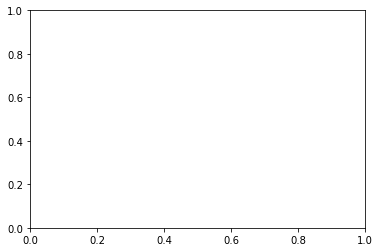

In [21]:
plt.pcolormesh(x, y, uc.get_in_units(results_dict['E_gsf'], e_A_unit))

In [ ]:
def meshsorter(x, y, z):
    